# VP graph similarity

 author: Steeve Laquitaine

 TABLE OF CONTENTS

 * Packages
 * Paths
 * Text to VP graph
 * VP graph similarity
   * Edit distance
   * Jaccard distance
   * Longest common contiguous subsequence (LCS)
 * VP graph clustering
 * Interpretation

 PACKAGES

In [86]:
import os
from difflib import SequenceMatcher

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

proj_path = "/Users/steeve_laquitaine/desktop/CodeHub/intent/"
os.chdir(proj_path)
from intent.src.intent.nodes import graphs, parsing


# PATHS

In [87]:
raw_data_path = proj_path + "intent/data/01_raw/banking77/train.csv"
cfg_data_path = (
    proj_path + "intent/data/02_intermediate/cfg_25_02_2021_18_16_42.xlsx"
)
# load dataset containing context free grammar productions
cfg = pd.read_excel(cfg_data_path)


# TEXT TO GRAPH

In [88]:
# convert each Verb Phrase to a single graph
constt = parsing.chunk_cfg(cfg["cfg"])
graphs_of_VPs = [
    graphs.from_text_to_graph(pd.Series(vp), isdirected=True, isweighted=True)
    for vp in constt.to_list()
]


# VP GRAPH SIMILARITY

## Edit distance

 Calculate the total edit operation cost needed to make the two graphs isomorphic.

In [89]:
# graph edit distance's cost functions
def node_subst_cost(node1, node2):
    if node1 == node2:
        return 0
    return 1


def node_del_cost(node):
    return 1


def node_ins_cost(node):
    return 1


def edge_subst_cost(edge1, edge2):
    if edge1 == edge2:
        return 0
    return 1


def edge_del_cost(node):
    return 1  # here you apply the cost for edge deletion


def edge_ins_cost(node):
    return 1  # here you apply the cost for edge insertion



In [90]:
# calculate (TODO: speed up)
n_graphs = len(graphs_of_VPs)
ged_sim = np.zeros((n_graphs, n_graphs))
for ix in range(n_graphs):
    for jx in range(n_graphs):
        ged_sim[ix, jx] = nx.graph_edit_distance(
            graphs_of_VPs[ix],
            graphs_of_VPs[jx],
            node_subst_cost=node_subst_cost,
            node_del_cost=node_del_cost,
            node_ins_cost=node_ins_cost,
            edge_subst_cost=edge_subst_cost,
            edge_del_cost=edge_del_cost,
            edge_ins_cost=edge_ins_cost,
        )

<Figure size 720x720 with 0 Axes>

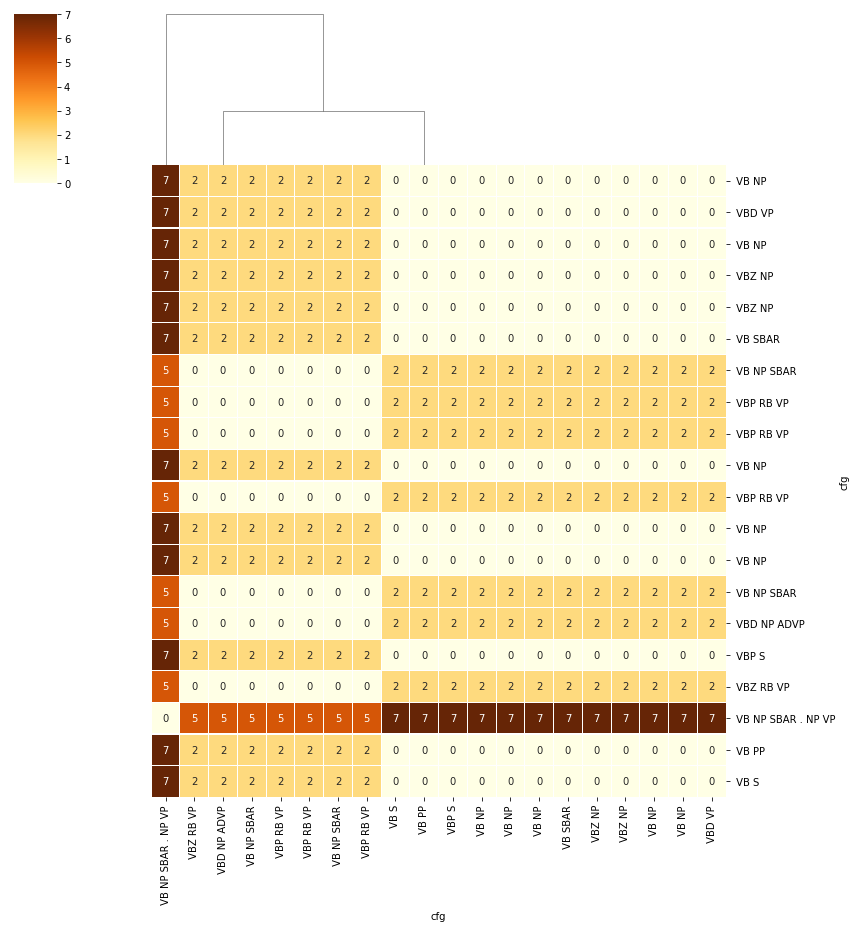

In [91]:
# preview sample cluster VP productions (hierar. clustering)
fig = plt.figure(figsize=(10, 10))
n_sample = 20
similarity_df = pd.DataFrame(
    ged_sim[:n_sample, :n_sample],
    index=constt[:n_sample],
    columns=constt[:n_sample],
)
cm = sns.clustermap(
    similarity_df,
    row_cluster=False,
    method="average",
    linewidths=0.15,
    figsize=(12, 13),
    cmap="YlOrBr",
    annot=ged_sim[:n_sample, :n_sample],
)

<Figure size 720x720 with 0 Axes>

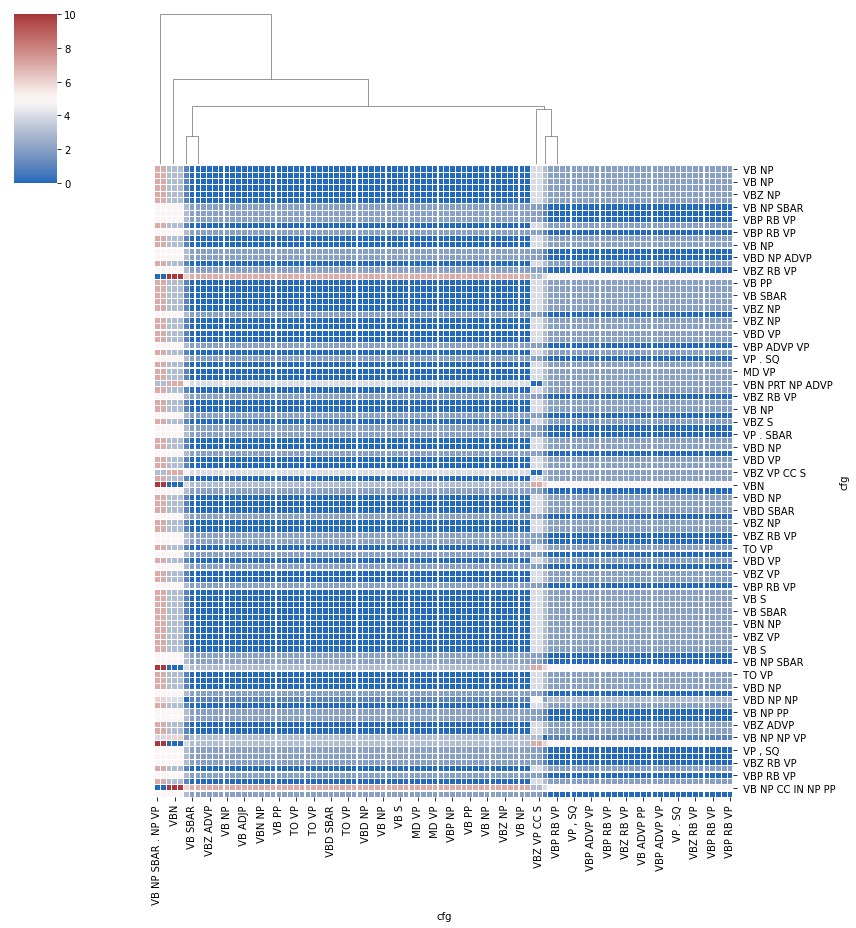

In [92]:
# Cluster VP productions (hierar. clustering)
fig = plt.figure(figsize=(10, 10))
cm = sns.clustermap(
    pd.DataFrame(ged_sim, index=constt, columns=constt),
    row_cluster=False,
    method="average",
    linewidths=0.15,
    figsize=(12, 13),
    cmap="vlag",
)

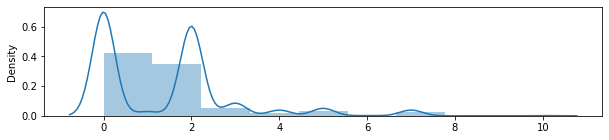

In [93]:
fig = plt.figure(figsize=(10, 2))
dist = sns.distplot(ged_sim, bins=len(np.unique(ged_sim)))



 **Graph ('VB','NP') and ('VBD','VP') are `isomorphic`, thus GED is 0**. <br>
 This is not what we look for: we look for distance to `automorphism`. <br>
 [TODO]: consider "minimum common subgraph" distance (10)

In [94]:
nx.is_isomorphic(graphs_of_VPs[0], graphs_of_VPs[1])

True

 ideas
 * sorting productions should group similar productions together


## Jaccard distance
 [TODO]: implement

## Longest common (contiguous) subsequence (LCS)

 [TODO]: implement the efficient suffix tree algo instead of the dynamic programming one

In [95]:
def lcs_sim(str1: str, str2: str) -> float:
    """Calculate the length ratio of the longest common subsequence between two strings

    Args:
        str1 (str): string to match
        str2 (str): string to match

    Returns:
        float: length ratio of the longest common subsequence b/w str1 and str2
    """
    s = SequenceMatcher(None, str1, str2)
    match = s.find_longest_match(0, len(str1), 0, len(str2))
    match_content = str1[match.a : match.size]
    lcs_similarity = s.ratio()
    return lcs_similarity



In [96]:
# calculate lcs similarity matrix
n_query = len(constt)
lcs_similarity = np.zeros((n_query, n_query))
for ix in range(n_query):
    for jx in range(n_query):
        lcs_similarity[ix, jx] = lcs_sim(constt[ix], constt[jx])


<Figure size 720x720 with 0 Axes>

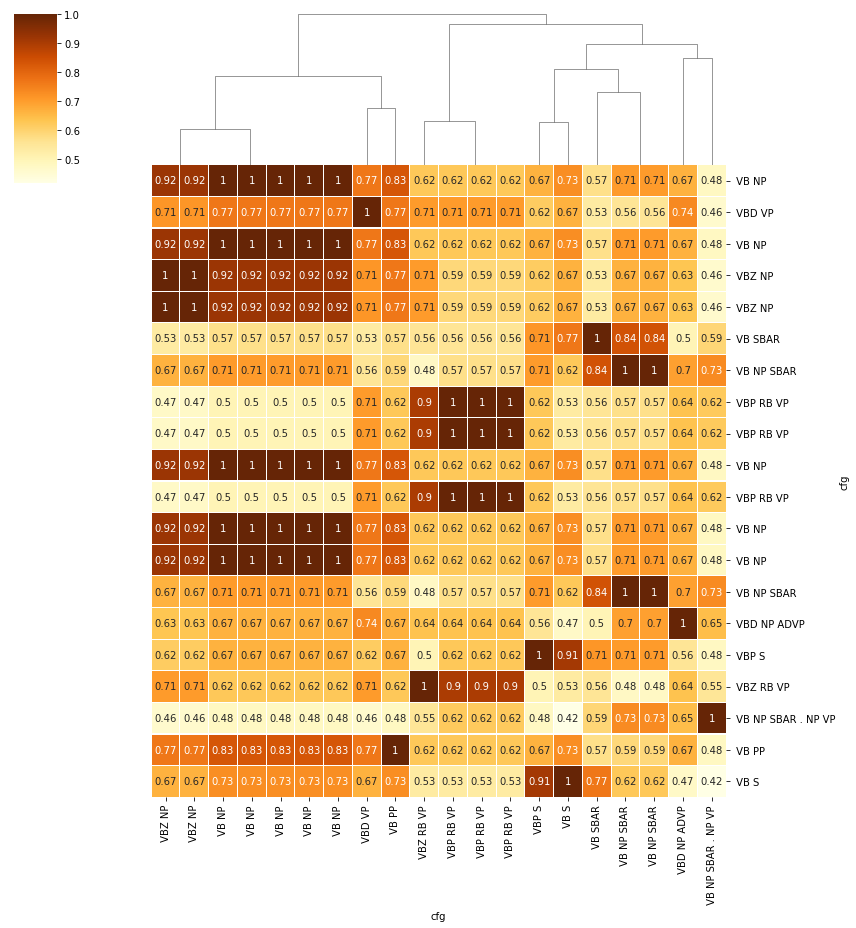

In [97]:
# preview sample cluster VP productions (hierar. clustering)
fig = plt.figure(figsize=(10, 10))
n_sample = 20
lcs_similarity_df = pd.DataFrame(
    lcs_similarity[:n_sample, :n_sample],
    index=constt[:n_sample],
    columns=constt[:n_sample],
)
cm = sns.clustermap(
    lcs_similarity_df,
    row_cluster=False,
    method="average",
    linewidths=0.15,
    figsize=(12, 13),
    cmap="YlOrBr",
    annot=lcs_similarity[:n_sample, :n_sample],
)

<Figure size 720x720 with 0 Axes>

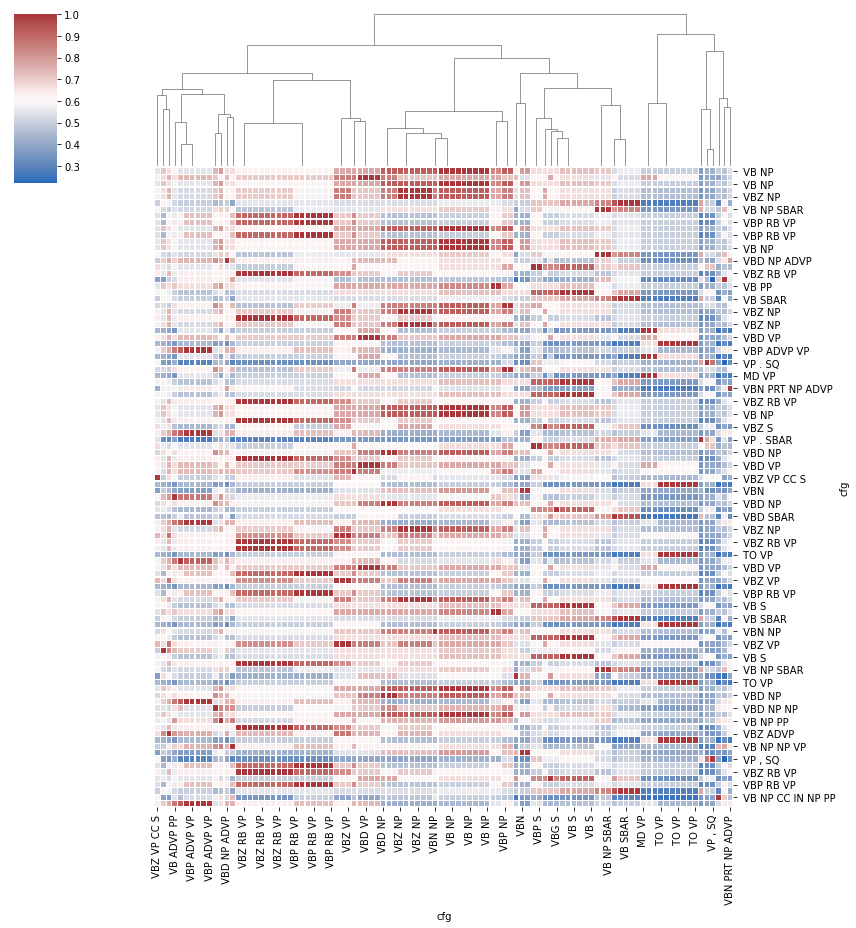

In [98]:
# Cluster VP productions based on lcs similarity (hierar. clustering)
fig = plt.figure(figsize=(10, 10))
cm = sns.clustermap(
    pd.DataFrame(lcs_similarity, index=constt, columns=constt),
    row_cluster=False,
    method="average",
    linewidths=0.15,
    figsize=(12, 13),
    cmap="vlag",
)

# References

 (6) https://en.wikipedia.org/wiki/Louvain_method <br>
 (5) https://cdlib.readthedocs.io/en/latest/reference/generated/cdlib.viz.plot_network_clusters.html#cdlib.viz.plot_network_clusters <br>
 (4) Fragkiskos D Malliaros and Michalis Vazirgiannis, “Clustering and Community Detection in Directed Networks: A Survey,” Physics Reports 533, no. 4 (2013): 95–142. <br>
 (3) https://github.com/Nath-B/Graph-Of-Words <br>
 (2) https://stackoverflow.com/questions/32441605/generating-ngrams-unigrams-bigrams-etc-from-a-large-text-of-txt-files-and-t  <br>
 (1) https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html <br>
 (7) https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html <br>
 (8) https://stackoverflow.com/questions/38705359/how-to-give-sns-clustermap-a-precomputed-distance-matri <br>
 (9) https://stackoverflow.com/questions/63927196/networkx-how-to-set-custom-cost-function <br>
 (10) https://stellargraph.readthedocs.io/en/stable/demos/embeddings/gcn-unsupervised-graph-embeddings.html <br>
 (11) https://stackoverflow.com/questions/61421491/similarity-measure-between-graphs-using-networkx
 (12) https://towardsdatascience.com/sequencematcher-in-python-6b1e6f3915fc

 jupyter nbconvert --no-input --to=pdf 2_Intent_parsing.ipynb
 to convert to notebook